In [20]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpldatacursor import datacursor
from mpldatacursor import HighlightingDataCursor
from scipy.optimize import curve_fit
import pickle
from scipy.optimize import minimize
from collections import Counter


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer

In [21]:
df = pd.read_pickle("../_generated_data/CovidTwitter_filtfreq.pkl")
df.head()

,id,sentiment,date,hashtags,city,state,place_type,City_file,freq,freq_boo
0,1240733265461272578,0.000000,Mar 19 2020,corona,Chicago,IL,city,Chicago,2129.0,True
1,1240781405623390209,0.000000,Mar 19 2020,TBT,Chicago,IL,city,Chicago,34.0,True
2,1240781405623390209,0.000000,Mar 19 2020,newnormal,Chicago,IL,city,Chicago,80.0,True
3,1240781405623390209,0.000000,Mar 19 2020,corona,Chicago,IL,city,Chicago,2129.0,True
4,1240786307539857409,0.033333,Mar 19 2020,corona,Chicago,IL,city,Chicago,2129.0,True


In [22]:
df.sort_values(by=['freq'], inplace=True, ascending=False)
df

,id,sentiment,date,hashtags,city,state,place_type,City_file,freq,freq_boo
20344,1285050018341126144,0.250000,Jul 20 2020,covid19,Riverside,CA,city,LosAngeles,5920.0,True
50406,1276690565493600262,0.136364,Jun 27 2020,covid19,Huntington Station,NY,city,NewYork,5920.0,True
50318,1276308681316020224,0.134549,Jun 26 2020,covid19,Manhattan,NY,city,NewYork,5920.0,True
50323,1276328575751335941,0.157576,Jun 26 2020,covid19,Manhattan,NY,city,NewYork,5920.0,True
17487,1275881031116058624,-0.050000,Jun 24 2020,covid19,Long Beach,CA,city,LosAngeles,5920.0,True
...,...,...,...,...,...,...,...,...,...,...
16479,1271175402128580608,0.000000,Jun 11 2020,nurses,West Covina,CA,city,LosAngeles,31.0,True
16473,1271175060716507138,0.000000,Jun 11 2020,nurses,West Covina,CA,city,LosAngeles,31.0,True
16468,1271174972069818369,0.000000,Jun 11 2020,nurses,West Covina,CA,city,LosAngeles,31.0,True
16396,1270457051307814912,0.008198,Jun 09 2020,riverside,Corona,CA,city,LosAngeles,31.0,True


In [23]:
df = df[['hashtags', 'freq']].drop_duplicates().reset_index(drop=True)
df

,hashtags,freq
0,covid19,5920.0
1,coronavirus,3192.0
2,SaveTheWorld,2652.0
3,Coronavirus,2608.0
4,BillionShields,2362.0
...,...,...
514,cincodemayo,31.0
515,liberalismisamentaldisorder,31.0
516,covidtesting,31.0
517,thanksgiving,31.0


In [24]:
df.sort_values(by=['freq'], inplace=True, ascending=False)
df['Freq_Rank']  = range(1, df.shape[0] +1)
df

,hashtags,freq,Freq_Rank
0,covid19,5920.0,1
1,coronavirus,3192.0,2
2,SaveTheWorld,2652.0,3
3,Coronavirus,2608.0,4
4,BillionShields,2362.0,5
...,...,...,...
497,foodbesat,31.0,515
496,visitLosAngeles,31.0,516
495,thisis51,31.0,517
494,cheflife,31.0,518


In [25]:
df.to_pickle("../_generated_data/df_hash.pkl")

In [36]:
def power_law(x, a, b):
    return a*np.power(x, b)
def slope(x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    return m

def loglik(b):
    df = pd.read_pickle("../_generated_data/df_hash.pkl")
    freqs = df['freq']
    x = df['Freq_Rank']
    # Power law function
    Probabilities = x**(-b)

    # Normalized
    Probabilities = Probabilities/Probabilities.sum()

    # Log Likelihoood
    Lvector = np.log(Probabilities)

    # Multiply the vector by frequencies
    Lvector = np.log(Probabilities) * freqs

    # LL is the sum
    L = Lvector.sum()

    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)

<IPython.core.display.Javascript object>


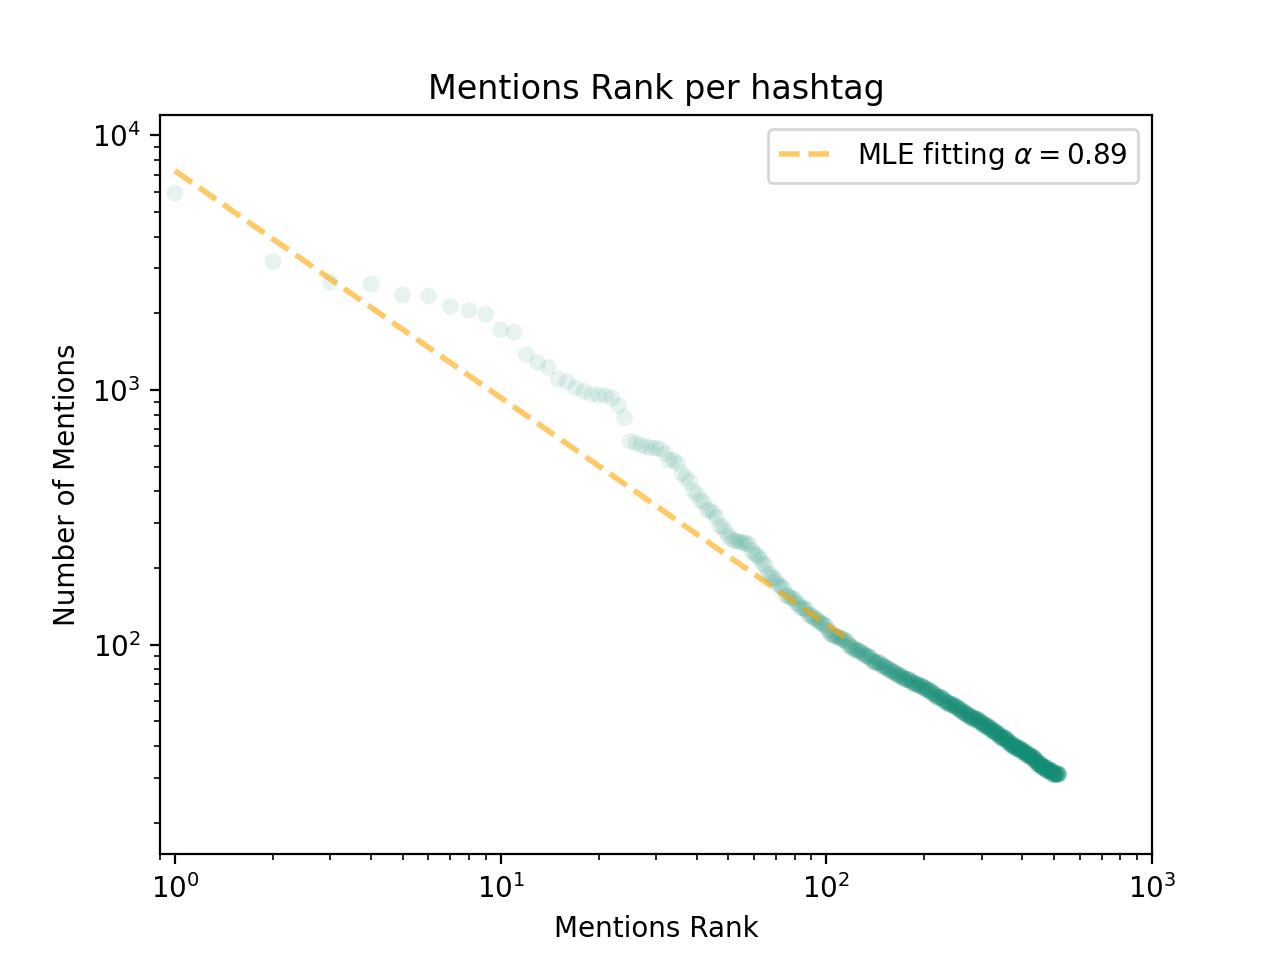

In [40]:
names = np.array(list(df['hashtags']))
ranks = df['Freq_Rank'].unique()
fig = plt.figure()
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

x = df['Freq_Rank']
y = df['freq']

plt.xlim(1, 100000000)
plt.ylim(1, 10000000)

y_n = np.asarray(df['freq'])
x_n = np.asarray(df['Freq_Rank'])

s_best = minimize(loglik, [2])
plt.plot(x_n[0:120], sum(x_n[0:120])*x_n[0:120]**-s_best.x, '--', color="orange", alpha = 0.6,
         linewidth=2,  label = r'MLE fitting $\alpha = {:.2f}$'.format(s_best.x.item()))

#print(s_best)

plt.legend()
#print('{:.4f}'.format(slope_fitted))    


i = 0
for n in names:
    ax.scatter(df['Freq_Rank'][i], df['freq'][i] , c='#138D75',
               alpha=0.1, edgecolors='none', label = df['hashtags'][i], marker = 'o')
    i += 1

plt.xlim(0.9, 1000)
plt.ylim(15, 12000)

plt.xlabel('Mentions Rank')
plt.ylabel('Number of Mentions')
ax.set_title('Mentions Rank per hashtag')
plt.savefig('../_generated_data/ZipfLaw', dpi = 1000)
datacursor(formatter='{label}'.format, display='multiple', draggable=True)
plt.show()